### Trade and Tariff Dataset at the County level

This notebook constructs a trade and county-level tariff data, over time, dataset. **This is a core notebook to the project** so I will try and explain each step clearly. This is one aspect of my code to be scrutinized. It outputs the county-level trade and tariff dataset as a `.parquet` file.

In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
file_path = os.getcwd()

fig_path = file_path +"\\figures"

### Step 1 Grab and manipulate the county level data for 2017

So we will grab the single file, then adjust it to suit our needs. The needs are to construct county-level employment weights to create a trade exposure metric and tariff metric for each county.

In [3]:
print("")
print("**********************************************************************************")
print("Downloading and processing BLS file")
print("")

url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

# SHOULD PRESPECIFY TYPES TO 

df.head()



**********************************************************************************

Type of zipfile object: <class 'zipfile.ZipFile'>


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


Then the file below cleans stuff up. The most important is the `NAICS_county_level` which selects the NAICS aggregation and then the county aggregation. Website describing this is here:

[https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm](https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm)

In [4]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 3 digit NAICS level

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...this mayb not be doing what I think it is...as it looks like these guys are there
# Does not matter as analysis is performed withthem, drop them when do the map. 

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

df_county.area_fips = df_county.area_fips.astype(str)

df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [5]:
df_national.reset_index(inplace = True)

In [6]:
df_national.rename({"annual_avg_emplvl":"nat_emplvl"}, axis = 1, inplace = True)

In [7]:
df_national.head()

,industry_code,nat_emplvl
0,111,534697
1,112,228471
2,113,45166
3,114,5005
4,115,352957


Let's compute annual employment. 

In [8]:
df_county.annual_avg_emplvl.sum()

115756851

which matches well with FRED (https://fred.stlouisfed.org/series/USPRIV) in 2017 (off by a couple million)

---
### Step 2 Bring in the trade data

Here we will read in data at the HS6 level, exports to china, over time. 

In [10]:
print("")
print("**********************************************************************************")
print("Downloading and processing Trade Data")
print("")

my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use 
url = url + my_key + "&time==from+2015-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

r = requests.get(url) 

df_china_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_china_trade.columns = r.json()[0]

df_china_trade.time = pd.to_datetime(df_china_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_china_trade["china_trade"] = df_china_trade.ALL_VAL_MO.astype(float)

df_china_trade.E_COMMODITY = df_china_trade.E_COMMODITY.astype(str)

df_china_trade.tail(10)


**********************************************************************************



,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE,china_trade
237620,903180,5700,24853152,CHINA,2020-03-01,HS6,5700,24853152.0
237621,903210,5700,577822,CHINA,2020-03-01,HS6,5700,577822.0
237622,903220,5700,522073,CHINA,2020-03-01,HS6,5700,522073.0
237623,903289,5700,13563850,CHINA,2020-03-01,HS6,5700,13563850.0
237624,903110,5700,875555,CHINA,2020-03-01,HS6,5700,875555.0
237625,903120,5700,325313,CHINA,2020-03-01,HS6,5700,325313.0
237626,903141,5700,29269424,CHINA,2020-03-01,HS6,5700,29269424.0
237627,903149,5700,8364672,CHINA,2020-03-01,HS6,5700,8364672.0
237628,903190,5700,7113393,CHINA,2020-03-01,HS6,5700,7113393.0
237629,903281,5700,1529240,CHINA,2020-03-01,HS6,5700,1529240.0


Now grab **total exports** (not just China) by HS6 level, overtime. 

In [11]:
r

<Response [200]>

In [12]:
end_use = "hs?get=E_COMMODITY,ALL_VAL_MO"

url = "https://api.census.gov/data/timeseries/intltrade/exports/"
url = url + end_use + my_key + "&time==from+2015-01" + "&COMM_LVL=HS6"

r = requests.get(url) 

df_all_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_all_trade.columns = r.json()[0]

df_all_trade.time = pd.to_datetime(df_all_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_all_trade["total_trade"] = df_all_trade.ALL_VAL_MO.astype(float)

df_all_trade.E_COMMODITY = df_all_trade.E_COMMODITY.astype(str)

df_all_trade.head(10)

,E_COMMODITY,ALL_VAL_MO,time,COMM_LVL,total_trade
0,600544,4546,2015-01-01,HS6,4546.0
1,600542,53239,2015-01-01,HS6,53239.0
2,600541,8175,2015-01-01,HS6,8175.0
3,600534,497405,2015-01-01,HS6,497405.0
4,600533,1993074,2015-01-01,HS6,1993074.0
5,600532,10793848,2015-01-01,HS6,10793848.0
6,600531,1621489,2015-01-01,HS6,1621489.0
7,600523,33574,2015-01-01,HS6,33574.0
8,600522,1305273,2015-01-01,HS6,1305273.0
9,600521,146116,2015-01-01,HS6,146116.0


Then combine the china trade and the all trade dataset.

In [13]:
dftrade = df_all_trade.merge(df_china_trade[["E_COMMODITY", "time","china_trade"]], left_on = ["E_COMMODITY", "time"], 
                             right_on = ["E_COMMODITY", "time"], how = "left")

dftrade.set_index("time", inplace = True)

dftrade.drop(["ALL_VAL_MO"], axis = 1, inplace = True)

---
### Step 3 Bring in concordance, create annual and national data set.

Assign Naics codes, create a annual 2017 `df`, create the trade wieghts by naics so we can aggregate the tariffs.

In [14]:
dftrade_17 = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"china_trade":"sum"})

Use the concordance from the US Census to go from HS6 to NAICS. In the code below there are two different approaches to working with the concordance. The latter one makes more sense. Ultimatly does not matter. 

In [15]:
alt_concordance = pq.read_table(".\\data\\alt_concordance.parquet").to_pandas()

alt_concordance.head()

dict_concordance = dict(zip(alt_concordance.hs6,alt_concordance.naics)) 

Then create this at different levels

In [16]:
dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"china_trade":"2017_china_trade"}, axis = 1, inplace = True)

In [17]:
dftrade_17.head()

,2017_china_trade,hs6,naics,naics4,naics3
E_COMMODITY,,,,,
010121,29098.0,010121,112920,1129,112
010129,27975.0,010129,112920,1129,112
010130,8340.0,010130,112920,1129,112
010190,0.0,010190,112920,1129,112
010221,80280.0,010221,11211X,1121,112


This look good, we have the commodity (as the index), chinese trade, and then different codes to map stuff to. 

Here we will work at the NAICS 3 digit level. The rational for this is that if you go more disaggregate, then confidentialy issues lead to employment at the county-level to be drpoed from the QECW. This is just a simple ``.groupby`` operation. 

In [18]:
dftrade_17_naics3 = dftrade_17.groupby("naics3").agg({"2017_china_trade": "sum"})

In [19]:
dftrade_17_naics3.head()

,2017_china_trade
naics3,
111,1.578543e+10
112,1.066820e+08
113,1.316022e+09
114,1.322142e+09
211,6.731515e+09


Now merge this with the national employment by naics data set.

In [20]:
df_national = df_national.merge(dftrade_17_naics3["2017_china_trade"],
                                left_on = "industry_code", right_index = True, how = "left")

In [21]:
df_national["2017_china_trade"].replace(np.nan, 0, inplace = True)

df_national["trd_wts"] = (df_national["2017_china_trade"]/df_national["2017_china_trade"].sum())

Then check to make sure that the trade weights sum up to one.

In [22]:
df_national.trd_wts.sum()

1.0

In [23]:
dftrade["hs6"] = dftrade.E_COMMODITY

dftrade["naics"] = dftrade["hs6"].map(dict_concordance)

dftrade["naics4"] = dftrade["naics"].str[0:4]

dftrade["naics3"] = dftrade["naics"].str[0:3]

---
### Step 4 Add in the tariff data...

Now here is one of the harder parts.

We want to take the time series data, then layer on the tariff data by product and time. So we will have a big data frame that is (at HS6 level) over time, but each unit of observation has the associated 2017 annual value and the tariff at that date. 

So we will use the `map` function to exploit this.

In [24]:
# bring in the tariff data

tariffs = pd.read_csv(".\\data\\new_tariff_list_2020.csv", dtype = {"hs6": str})
# This is the tariff dataset created by updated_tariff_data.ipynb (note the max tariff means taking the largest value
# when going from Chinese hs10 to hs6. This does not matter, if anything gives more conservative resutls)

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m")
# make sure the time is there.

tariffs.set_index("time_of_tariff",inplace = True)

In [25]:
grp = tariffs.groupby("time_of_tariff")

In [26]:
test = grp.tariff.median()

In [27]:
test

time_of_tariff
2018-01-01     8.0
2018-04-02     8.4
2018-05-01     8.4
2018-07-01     7.0
2018-07-06     7.0
2018-08-23     7.0
2018-09-24    15.5
2018-11-01    15.0
2019-01-02    15.0
2019-06-01    27.0
2019-09-01    28.0
2019-12-26    28.0
Name: tariff, dtype: float64

Then we create dictionaries to do the following " you tell me HS, I tell you tariff" by time. 

**Note this would be stuff to automate in the future**

In [28]:
initial_tariff = dict(zip(tariffs.loc["2018-01-01"].hs6,tariffs.loc["2018-01-01"].tariff)) 
# These are the initial mfn tariffs. We will apply these from 2017 up untill the changes...

tariff_dict_232 = dict(zip(tariffs.loc["2018-04-02"].hs6,tariffs.loc["2018-04-02"].tariff)) 
#These are the section 232 tariffs, response to US steel and aluminum. 

tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].hs6,tariffs.loc["2018-07-06"].tariff)) 
#tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff

tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].hs6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

#tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 2

tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].hs6,tariffs.loc[dt.datetime(2018,9,24)].tariff))
#tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 3

tariff_dict_mfn = dict(zip(tariffs.loc["2018-11-01"].hs6,tariffs.loc["2018-11-01"].tariff))
# This reflects mfn adjustments that China made later in the year.

#tariff_dict_mfn_2019 = dict(zip(tariffs.loc["2019-01-01"].hs6,tariffs.loc["2019-01-01"].tariff))
# This reflects mfn adjustments and auto adjustment China made at the start of 2019

tariff_dict_auto_2019 = dict(zip(tariffs.loc["2019-01-02"].hs6,tariffs.loc["2019-01-02"].tariff))
# This reflects auto adjustment China made at the start of 2019

tariff_dict_june_2019 = dict(zip(tariffs.loc["2019-06-01"].hs6,tariffs.loc["2019-06-01"].tariff))
# This reflects auto adjustment China made at the start of 2019

tariff_dict_august_2019 = dict(zip(tariffs.loc["2019-09-01"].hs6,tariffs.loc["2019-09-01"].tariff))
# This reflects auto adjustment China made at the start of 2019

tariff_dict_dec_2019 = dict(zip(tariffs.loc["2019-12-26"].hs6,tariffs.loc["2019-12-26"].tariff))
# This reflects auto adjustment China made at the start of 2019

Then assign the tariffs to the hs6 codes. As mentioned below, the ``.update`` function updates the product code with a new tariff if there is one in the new dictionary.

In [29]:
dftrade["tariff"] = 0

# Then use the map function which will fill in the tariff in the correct places..
# Note the key issue was that the dictionaries were overwritting stuff, hence
# the update...

# Start with the MFN...
dftrade.loc["2015-01":,"tariff"] = dftrade.loc["2015-01":,"hs6"].map(initial_tariff)

#print("done")
# Now update given the 232 response
initial_tariff.update(tariff_dict_232)

dftrade.loc["2018-04":,"tariff"] = dftrade.loc["2018-04":,"hs6"].map(initial_tariff)

#print("done")
# This is the big Phase 1 of the war
initial_tariff.update(tariff_dict_r1)

dftrade.loc["2018-07":,"tariff"] = dftrade.loc["2018-07":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 2
initial_tariff.update(tariff_dict_r2)

dftrade.loc["2018-09":,"tariff"] = dftrade.loc["2018-09":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 3
initial_tariff.update(tariff_dict_r3)

dftrade.loc["2018-10":,"tariff"] = dftrade.loc["2018-10":,"hs6"].map(initial_tariff)

#print("done")
# China then adjusts the mfn
initial_tariff.update(tariff_dict_mfn)

dftrade.loc["2018-11":,"tariff"] = dftrade.loc["2018-11":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_auto_2019)

dftrade.loc["2019-01":,"tariff"] = dftrade.loc["2019-01":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_june_2019)

dftrade.loc["2019-06":,"tariff"] = dftrade.loc["2019-06":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_august_2019)

dftrade.loc["2019-09":,"tariff"] = dftrade.loc["2019-09":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_dec_2019)
dftrade.loc["2019-12":,"tariff"] = dftrade.loc["2019-12":,"hs6"].map(initial_tariff)

dftrade["tariff"] = dftrade["tariff"].replace(np.nan,0)

dftrade[dftrade["tariff"] == 25].head()

dftrade["2018-08"].head(25)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff
time,,,,,,,,,
2018-08-01,210610,HS6,63955786.0,1747658.0,210610,311224,3112,311,10.0
2018-08-01,210690,HS6,450942802.0,30439670.0,210690,311999,3119,311,35.0
2018-08-01,220110,HS6,4502684.0,74971.0,220110,312112,3121,312,5.0
2018-08-01,220190,HS6,10319476.0,89852.0,220190,312113,3121,312,5.0
2018-08-01,220210,HS6,36633830.0,133214.0,220210,312111,3121,312,5.0
2018-08-01,220291,HS6,864888.0,0.0,220291,312120,3121,312,5.0
2018-08-01,220299,HS6,68609169.0,1117459.0,220299,312111,3121,312,5.0
2018-08-01,220300,HS6,71734696.0,1099062.0,220300,312120,3121,312,0.0
2018-08-01,220410,HS6,6888129.0,261414.0,220410,312130,3121,312,29.0


This is looking good, not how you can see the tariffs (in august of 2018) hitting in the right places.

Now merge it with the 2017 annual trade data so we can construct trade weighted averages of tariffs....

In [30]:
dftrade = dftrade.merge(dftrade_17["2017_china_trade"], how = "inner", left_on = "E_COMMODITY", right_index = True)

In [31]:
dftrade[dftrade.naics3 == "111"].sort_values(by = ["tariff"], ascending = False)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff,2017_china_trade
time,,,,,,,,,,
2019-09-01,100610,HS6,3.178522e+07,NaN,100610,111160,1111,111,90.0,0.0
2018-07-01,100590,HS6,1.239735e+09,224574.0,100590,111150,1111,111,90.0,151883243.0
2019-06-01,100119,HS6,1.324554e+07,NaN,100119,111140,1111,111,90.0,0.0
2019-05-01,100119,HS6,2.531423e+07,NaN,100119,111140,1111,111,90.0,0.0
2019-04-01,100119,HS6,1.282655e+07,NaN,100119,111140,1111,111,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2016-08-01,120925,HS6,1.067244e+07,1496597.0,120925,111998,1119,111,0.0,27368255.0
2016-08-01,120921,HS6,1.081452e+07,0.0,120921,111998,1119,111,0.0,2661790.0
2016-09-01,120921,HS6,1.720998e+07,0.0,120921,111998,1119,111,0.0,2661790.0


Looks like we accomplished this task.

Now what we will do is create a function which will make the trade weighted verage of the tariff rates as we aggregate across product codes.

In [32]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_china_trade"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_china_trade"].sum()
    
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["total_trade"].sum(),
          "china_trade" : df["china_trade"].sum()}
    
    return pd.DataFrame(foo)

Now, `groupby` time and NAICS code (in this case 3), apply the trade weighted function above. Then the resulting data frame should be time, and naics tariffs and the total trade. 

In [33]:
grp = dftrade.groupby(["time","naics3"])

exp_trf_bynaics = grp.apply(trd_weighted_avg)

exp_trf_bynaics = exp_trf_bynaics.droplevel(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [34]:
exp_trf_bynaics.to_csv(".//data//exports_by_naics.csv")

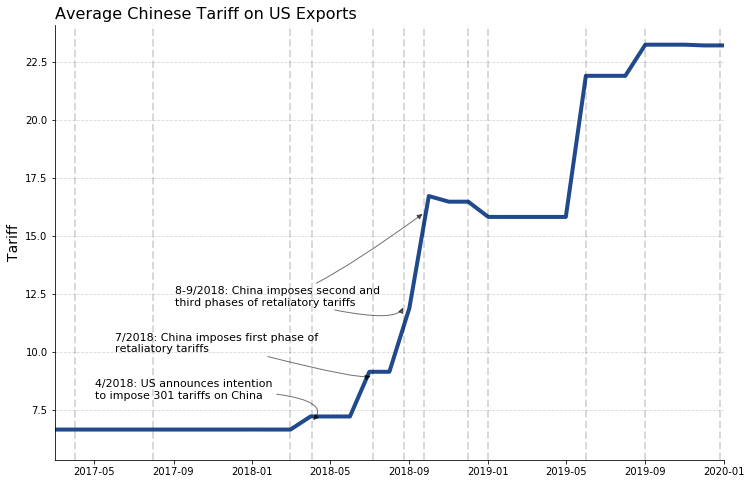

In [35]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

tariffs_over_time = exp_trf_bynaics.groupby(["time"]).agg({"tariff_trd_w_avg": "mean"})

ax.plot(tariffs_over_time, alpha = 0.95, color = mike_blue, linewidth = 4)

#ax.plot(auto_least, alpha = 0.95, color = mike_blue, linewidth = 4, 
#        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_xlim(dt.datetime(2017,3,1),dt.datetime(2020,1,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

label_descrip = "Tariff"

ax.set_ylabel(label_descrip, fontsize = 14)

ax.axvline(dt.datetime(2017,4,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2017,8,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,3,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,1,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,6,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,9,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,12,26), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.set_title("Average Chinese Tariff on US Exports", fontsize = 16, loc= "left" )


##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose 301 tariffs on China", 
    xy=(dt.datetime(2018,4,3), 7), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,5,3), 8), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=0,angleB=45",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), 9), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,3), 10), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), 12), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,9,3), 12), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), 16), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,9,3), 12), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=3,angleB=36",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################


##############################################################################################

#

if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
#plt.savefig(fig_path + "\\tariffs_time.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

This simple plot looks a lot like the Bowen figures. Note that the dip is all about China changing their MFN tariffs in (what appears to be) certain consumer orinted catagories as Bowen point out. So clothing stuff falls, while they are hammering the ag. products. 

Looks like we accomplished this task. Just a couple of things to clean up then we are ready to move onto the next step. 

In [36]:
exp_trf_bynaics["time"] = exp_trf_bynaics.index.get_level_values(0)

In [37]:
exp_trf_bynaics = exp_trf_bynaics.droplevel(level=0)

In [38]:
exp_trf_bynaics.loc["111"]

,tariff_trd_w_avg,total_trade,china_trade,time
naics3,,,,
111,7.731278,6.628535e+09,2.260464e+09,2015-01-01
111,7.738917,5.939264e+09,1.496540e+09,2015-02-01
111,7.738919,5.772844e+09,1.079484e+09,2015-03-01
111,7.738919,4.840803e+09,6.281327e+08,2015-04-01
111,7.738919,4.459799e+09,3.796146e+08,2015-05-01
...,...,...,...,...
111,37.088876,6.396097e+09,1.864155e+09,2019-11-01
111,37.088876,5.803267e+09,1.150412e+09,2019-12-01
111,37.088994,5.538112e+09,9.438573e+08,2020-01-01


---

### Step 3 Merge trade data with the county data

This is the most time consuming step (interms of compuation time). So start with the county data set, `groupby` county, then apply a function which will create (i) time varying exports (which are constructed with the 2017 weightes) and (ii) time varying tariffs (also constructed using the 2017) weights. 

The final want is a big dataframe that has county, time, export exposure and tariff exposure. 

In [39]:
print("")
print("**********************************************************************************")
print("Constructing County-Level Tariffs and Exports")
print("")


**********************************************************************************
Constructing County-Level Tariffs and Exports



In [40]:
grp = df_county.groupby("area_fips")

# This creates groups at the county level.

In [41]:
# Let's just look at one of the groups...

grp.get_group("1001").head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3016,1001,5,111,75,0,2017,N,4,0,0,0,1
3026,1001,5,112,75,0,2017,NaN,3,27,848146,31905,1
3033,1001,5,113,75,0,2017,NaN,4,36,2901165,80032,1
3040,1001,5,115,75,0,2017,NaN,9,27,2007731,74132,1
3052,1001,5,212,75,0,2017,N,4,0,0,0,1


Below are the two key functions that deliver this. Basically it does the following: 

- Take a group at county level, merge it with the national level data set, so the resulting `df` has the county and nation.

- Create the weights. 

- Then merge it with the exports, this will now be a df with exports varying over time, but with the fixed weights associated with each entry.

- Then aggregate the national exports by NAICS by the county level weights, giving a county level time series of exports.

---

**Updates**

- The tariff measure does the following: fix a county, take employment in industry $i$ and divide by total county employment, then sum up tariffs across industries with the weights being the county level share. The idea here is if all employment in a county is soy, then the "effective" tariff that the county faces is the soy tariff.

In equation terms: here $c$ is county, $s$ is industry, $n$, below is nation.

$\tau_{c,t} = \sum_{s\in S}\frac{L_{c,s}}{L_{c,S}} \tau_{s,t}$

Note that below, I make one further adjustment to make sure that $L_{c,S}$ is for all employment, not just the sum across $L_{c,s}$


- The export measure: What am I doing: take a county's employment in industry $i$ and divide by **national** level employment in industry $i$. Then a "county's" exports is the the sum across industries, weighted by the county's share of national employment in each industry. The idea here is, if a county's has all national level employment in an industry, all that industries exports will be assigned to that county.

$\mbox{EX}_{c,t} = \frac{1}{L_{c,S,2017}}\sum_{s\in S}\frac{L_{c,s,2017}}{L_{n,s,2017}} \mbox{EX}_{s,t}$

and then I divide by total employment in the county to have a county per worker measure. This is done for exports to China and then export in total. Note that below, I make one further adjustment to make sure that $L_{c,S}$ is for all employment, not just the sum across $L_{c,s}$




In [42]:
def create_trade_weights(df):
    # Takes in the county groupings and will return, for each county, a time series of export
    # exposure, tariffs, and other statistics. 

    new_df = df.merge(df_national[["nat_emplvl",
                                   "industry_code", "trd_wts"]],
                                  how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
        
    new_df["emp_wts"] = (new_df.annual_avg_emplvl/new_df.nat_emplvl)
     
    # create the weights...
        
    foo_df = exp_trf_bynaics.merge(new_df[["emp_wts","trd_wts",
                                           "industry_code",
                                          "annual_avg_emplvl"]], left_index = True, right_on = "industry_code")  
    
    # Now each weight is for a NAICS code, we will merge it with the export trade data set, so for all naics, all time...
    # This is a big df whith all trade data and then the county's weights for each naics code
    
    foo_grp = foo_df.groupby("time")
    
    # group by time. 
    
    foo = foo_grp.apply(trade_by_naics)
    
    # Then for each time gropuing, we aggregate across the naics codes according to the weights above.
    
    foo = foo.droplevel(1)
    
    foo["fips"] = df["area_fips"].astype(str).iloc[0]
    
    # some cleaning of the df
    
    foo["total_employment"] = new_df.annual_avg_emplvl.sum()
    
    # get total employment.
    
    return pd.DataFrame(foo)
    

In [43]:
def trade_by_naics(df):
    # Simple function just to test about aggregation 

    china_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["china_trade"]*df["emp_wts"]).sum()
    
    total_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["total_trade"]*df["emp_wts"]).sum()
    # the first term multiplies trade by the county's share of national level employment
    # then the outside term divides by number of workers in a county. 
    
    #tariff_nwt_pc = (1/df["annual_avg_emplvl"].sum())*(df["tariff_trd_w_avg"]*df["emp_wts"]).sum()
    # This is the measure that makes most sense, need to justify it...
    tariff =  ((df["annual_avg_emplvl"]*df["tariff_trd_w_avg"])/df["annual_avg_emplvl"].sum()).sum()
    # local employment share weighted tariff. So if all guys are in area are working in soy,
    # then they are facing the soybean tariff....
    
    foo = {"total_exp_pc": [total_exp_pc],
          "china_exp_pc": [china_exp_pc],
           "tariff": [tariff],
          "emplvl_2017": df["annual_avg_emplvl"].sum()}

    return pd.DataFrame(foo)

Then apply the function to the county groups

In [44]:
trade_county = grp.apply(create_trade_weights)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


And we are done and output the file to where we want it

In [45]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(25)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                              
37173     2019-09-01    3701.349055     43.042283  41.191970         52.0   
          2019-10-01    3648.238229     65.482914  41.191970         52.0   
          2019-11-01    3097.551968     73.877718  41.191970         52.0   
          2019-12-01    3029.967626     63.510217  41.191970         52.0   
          2020-01-01    3095.344709     22.650806  41.191970         52.0   
          2020-02-01    3020.463369     17.686145  41.191970         52.0   
          2020-03-01    3264.840000     24.012574  41.191970         52.0   
2016      2020-01-01   40898.050350   6179.118482  41.001301         16.0   
25999     2020-01-01   40898.050350   6179.118482  41.001301          6.0   
2999      2020-01-01   40898.050350   6179.118482  41.001301          6.0   
2016      2019-09-01  128468.059740  19783.599201  40.985083         16.0   
          2019-10-01  113067.458142  17043.953447  40.985083         16.0   
          2019-11-01   80694.580420  12128.569231  40.985083         16.0   
          2019-12-01   54434.793606   7386.146853  40.985083         16.0   
25999     2019-09-01  128468.059740  19783.599201  40.985083          6.0   
          2019-10-01  113067.458142  17043.953447  40.985083          6.0   
          2019-11-01   80694.580420  12128.569231  40.985083          6.0   
          2019-12-01   54434.793606   7386.146853  40.985083          6.0   
2999      2019-09-01  128468.059740  19783.599201  40.985083          6.0   
          2019-10-01  113067.458142  17043.953447  40.985083          6.0   
          2019-11-01   80694.580420  12128.569231  40.985083          6.0   
          2019-12-01   54434.793606   7386.146853  40.985083          6.0   
2016      2020-03-01   94401.769431  16183.737862  40.984585         16.0   
25999     2020-03-01   94401.769431  16183.737862  40.984585          6.0   
2999      2020-03-01   94401.769431  16183.737862  40.984585          6.0   

                       fips  total_employment  
area_fips time                                 
37173     2019-09-01  37173            2505.0  
          2019-10-01  37173            2505.0  
          2019-11-01  37173            2505.0  
          2019-12-01  37173            2505.0  
          2020-01-01  37173            2505.0  
          2020-02-01  37173            2505.0  
          2020-03-01  37173            2505.0  
2016      2020-01-01   2016             449.0  
25999     2020-01-01  25999           16461.0  
2999      2020-01-01   2999             380.0  
2016      2019-09-01   2016             449.0  
          2019-10-01   2016             449.0  
          2019-11-01   2016             449.0  
          2019-12-01   2016             449.0  
25999     2019-09-01  25999           16461.0  
          2019-10-01  25999           16461.0  
          2019-11-01  25999           16461.0  
          2019-12-01  25999           16461.0  
2999      2019-09-01   2999             380.0  
          2019-10-01   2999             380.0  
          2019-11-01   2999             380.0  
          2019-12-01   2999             380.0  
2016      2020-03-01   2016             449.0  
25999     2020-03-01  25999           16461.0  
2999      2020-03-01   2999             380.0

**One more adjustment.** Notice that in the function, when we are merging, we are droping all the NAICS codes without trade. So these measures (total trade, china trade, and tariffs) are only conditional on being traded. This only matters in so far as the denominator, the ``df["annual_avg_emplvl"].sum()`` is concerned. 

To make the adjustment then, we multiply the employment measure in the denominator and then divide through by the ``total_employment`` measure. 

In [46]:
trade_county["tariff"] = (trade_county["emplvl_2017"]/
                              trade_county["total_employment"])*trade_county["tariff"]

trade_county["china_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["china_exp_pc"]

trade_county["total_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["total_exp_pc"]

In [47]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(50)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                             
53023     2020-01-01  10357.476429   1765.219079  37.088994         37.0   
28055     2020-01-01  10357.476429   1765.219079  37.088994         21.0   
53023     2019-09-01   8272.728399    976.810515  37.088876         37.0   
          2019-10-01  10684.790352   1617.974212  37.088876         37.0   
          2019-11-01  11962.096627   3486.375899  37.088876         37.0   
          2019-12-01  10853.374464   2151.520949  37.088876         37.0   
          2020-03-01  10093.658070    638.361883  37.088876         37.0   
28055     2019-09-01   8272.728399    976.810515  37.088876         21.0   
          2019-10-01  10684.790352   1617.974212  37.088876         21.0   
          2019-11-01  11962.096627   3486.375899  37.088876         21.0   
          2019-12-01  10853.374464   2151.520949  37.088876         21.0   
          2020-03-01  10093.658070    638.361883  37.088876         21.0   
53023     2020-02-01   9774.603662    714.315089  37.088873         37.0   
28055     2020-02-01   9774.603662    714.315089  37.088873         21.0   
48229     2020-01-01   9487.764668   1616.994576  33.974651        120.0   
          2019-09-01   7578.071816    894.788258  33.974543        120.0   
          2019-10-01   9787.594216   1482.113782  33.974543        120.0   
          2019-11-01  10957.645765   3193.626778  33.974543        120.0   
          2019-12-01   9942.022410   1970.858885  33.974543        120.0   
          2020-03-01   9246.098995    584.758977  33.974543        120.0   
          2020-02-01   8953.835415    654.334432  33.974541        120.0   
53023     2019-06-01   9071.415764   1534.950789  32.880038         37.0   
          2019-07-01   9002.619207   1584.548413  32.880038         37.0   
          2019-08-01   9353.938784   2063.342059  32.880038         37.0   
28055     2019-06-01   9071.415764   1534.950789  32.880038         21.0   
          2019-07-01   9002.619207   1584.548413  32.880038         21.0   
          2019-08-01   9353.938784   2063.342059  32.880038         21.0   
53023     2019-03-01  10871.646688   1207.755065  32.843841         37.0   
          2019-04-01   9720.978332    682.462529  32.843841         37.0   
          2019-05-01   9564.543414   1239.255085  32.843841         37.0   
28055     2019-03-01  10871.646688   1207.755065  32.843841         21.0   
          2019-04-01   9720.978332    682.462529  32.843841         21.0   
          2019-05-01   9564.543414   1239.255085  32.843841         21.0   
53023     2019-02-01  10440.790650   1605.624408  32.843840         37.0   
28055     2019-02-01  10440.790650   1605.624408  32.843840         21.0   
53023     2018-10-01  11077.880433    341.748327  32.843688         37.0   
          2018-11-01  11098.423631    245.768800  32.843688         37.0   
          2018-12-01  10359.291167    325.183876  32.843688         37.0   
28055     2018-10-01  11077.880433    341.748327  32.843688         21.0   
          2018-11-01  11098.423631    245.768800  32.843688         21.0   
          2018-12-01  10359.291167    325.183876  32.843688         21.0   
53023     2019-01-01  10738.715609   1055.003978  32.842474         37.0   
28055     2019-01-01  10738.715609   1055.003978  32.842474         21.0   
53023     2018-07-01   9751.343396    363.359785  32.810320         37.0   
          2018-08-01   8796.029329    250.216820  32.810320         37.0   
          2018-09-01   8501.304814    157.381511  32.810320         37.0   
28055     2018-07-01   9751.343396    363.359785  32.810320         21.0   
          2018-08-01   8796.029329    250.216820  32.810320         21.0   
          2018-09-01   8501.304814    157.381511  32.810320         21.0   
2013      2020-01-01   4134.348547    297.667856  32.446041       1895.0   

                       fips  total_employment  
area_fips time       

In [48]:
exposure = pd.qcut(trade_county.xs('2015-1-1', level=1).tariff, 4 ,labels = False)

In [49]:
most_exposed = exposure[exposure == 3].index.tolist()

trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff.mean()

6.293152791313937

In [50]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key

c = Census(my_api_key)
# This will create an object c which has methods associated with it.
# We will see  these below.

type(c) 
# Per the discussion below, try c.tab and see the options. 

code = ("NAME","B01001_001E","B19013_001E") # Same Codes:

county_2017 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2017))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
        
county_2017 = county_2017.rename(columns = {"B01001_001E":"2017_population", "B19013_001E":"2017_income"})

county_2017["GEOFIPS"] = (county_2017["state"] + county_2017["county"]).astype(int)

county_2017["2017_population"] = county_2017["2017_population"].astype(float)

county_2017["2017_income"] = county_2017["2017_income"].astype(float)

county_2017.set_index(["GEOFIPS"], inplace = True)

In [51]:
trade_county.reset_index(inplace = True)

trade_county["int_area_fips"] = trade_county["area_fips"].astype(int)

trade_county = trade_county.merge(county_2017[["2017_income","2017_population"]],
                                  left_on = "int_area_fips", right_index = True, how = "left")

#trade_employ.drop(labels = "index", axis = 1, inplace = True)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [ ]:
file_path = os.getcwd() + "\\data"+ "\\exports_trade_data_2020.parquet"

pq.write_table(pa.Table.from_pandas(trade_county.reset_index()), file_path)

C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:383: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  'start': level._start,
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:384: FutureWarning: RangeIndex._stop is deprecated and will be removed in a future version. Use RangeIndex.stop instead
  'stop': level._stop,
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:385: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  'step': level._step


In [ ]:
trade_county.head()